# **Image Segmentation Techniques**
**Required Packages**:  
`!pip install numpy matplotlib opencv-python scikit-image ipywidgets`

## **3.1 Thresholding**
### **Theory**
Segmentation based on intensity values:

**Global Thresholding**:
$$ g(x,y) = \begin{cases} 
1 & \text{if } f(x,y) > T \\
0 & \text{otherwise}
\end{cases} $$

**Otsu's Method**:
Automatically determines optimal threshold by minimizing intra-class variance:
$$ \sigma_w^2(t) = \omega_0(t)\sigma_0^2(t) + \omega_1(t)\sigma_1^2(t) $$
Where $\omega$ are class probabilities and $\sigma^2$ are variances

*Reference: Gonzalez & Woods, Chapter 10*

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Thresholding Demo
def thresholding_demo(image_path='grayscale_image.jpg'):
    img = cv2.imread(image_path, 0)

    @interact(method=['binary', 'adaptive', 'otsu'], threshold=(0, 255, 5))
    def apply_threshold(method='otsu', threshold=127):
        if method == 'binary':
            _, thresh = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        elif method == 'adaptive':
            thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)
        else:
            _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        plt.figure(figsize=(10,5))
        plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original')
        plt.subplot(122), plt.imshow(thresh, cmap='gray'), plt.title(f'{method.capitalize()} Thresholding')
        plt.show()

thresholding_demo('img.png')

interactive(children=(Dropdown(description='method', index=2, options=('binary', 'adaptive', 'otsu'), value='o…

## **3.2 Edge Detection**
### **Theory**
**Canny Edge Detector**:
1. Gaussian smoothing
2. Gradient calculation (Sobel operators)
3. Non-maximum suppression
4. Hysteresis thresholding

**Sobel Operator**:
$$ G_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}, 
   G_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix} $$
$$ \text{Gradient magnitude} = \sqrt{G_x^2 + G_y^2} $$

*Reference: Marr & Hildreth, 1980*

In [6]:
def edge_detection_demo(image_path='brain_mri.jpg'):
    img = cv2.imread(image_path, 0)
    
    @interact(method=['sobel', 'canny'], low_thresh=(0, 255, 5), high_thresh=(0, 255, 5))
    def detect_edges(method='canny', low_thresh=50, high_thresh=150):
        if method == 'sobel':
            grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
            edges = np.sqrt(grad_x**2 + grad_y**2)
        else:
            edges = cv2.Canny(img, low_thresh, high_thresh)
            
        plt.figure(figsize=(10,5))
        plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original')
        plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title(f'{method.capitalize()} Edges')
        plt.show()
        
edge_detection_demo('img.png')

interactive(children=(Dropdown(description='method', index=1, options=('sobel', 'canny'), value='canny'), IntS…

## **3.3 Region-Based Segmentation**
### **Theory**
**Region Growing**:
1. Select seed points
2. Merge neighboring pixels with similar properties
3. Stop when no more pixels can be added

**Watershed Algorithm**:
1. Compute distance transform
2. Create markers
3. Apply watershed transformation

$$ D(x,y) = \min_{(i,j)\in B} \sqrt{(x-i)^2 + (y-j)^2} $$
Where $B$ is the boundary set

*Reference: Vincent & Soille, 1991*

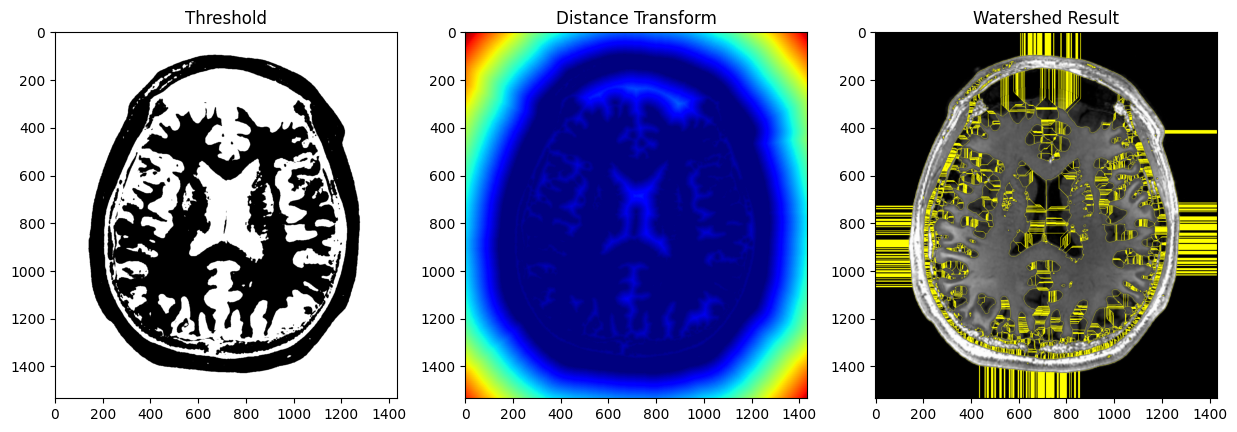

In [7]:
from skimage.segmentation import watershed, mark_boundaries
from skimage.feature import peak_local_max

def watershed_demo(image_path='cells.jpg'):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Distance transform
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    coords = peak_local_max(dist, footprint=np.ones((3,3)), labels=thresh)
    
    # Markers
    markers = np.zeros(dist.shape, dtype=np.int32)
    for i, (x,y) in enumerate(coords):
        markers[x,y] = i+1
        
    # Watershed
    labels = watershed(-dist, markers, mask=thresh)
    
    plt.figure(figsize=(15,5))
    plt.subplot(131), plt.imshow(thresh, cmap='gray'), plt.title('Threshold')
    plt.subplot(132), plt.imshow(dist, cmap='jet'), plt.title('Distance Transform')
    plt.subplot(133), plt.imshow(mark_boundaries(img, labels)), plt.title('Watershed Result')
    plt.show()
    
watershed_demo('img.png')

## **Exercises**
1. Implement manual Otsu thresholding
2. Create custom edge detection kernel
3. Implement basic region growing algorithm

## **Solutions**
### **Exercise 3.1: Manual Otsu**

In [ ]:
def otsu_threshold(image):
    hist = cv2.calcHist([image], [0], None, [256], [0,256]).ravel()
    hist_norm = hist / hist.sum()
    
    best_var = 0
    best_thresh = 0
    
    for t in range(1, 255):
        w0 = hist_norm[:t].sum()
        w1 = hist_norm[t:].sum()
        
        if w0 == 0 or w1 == 0:
            continue
            
        mu0 = (np.arange(t) * hist_norm[:t]).sum() / w0
        mu1 = (np.arange(t,256) * hist_norm[t:]).sum() / w1
        
        var = w0 * w1 * (mu0 - mu1)**2
        
        if var > best_var:
            best_var = var
            best_thresh = t
            
    return best_thresh

# Usage
img = cv2.imread('grayscale_image.jpg', 0)
t = otsu_threshold(img)
_, thresh = cv2.threshold(img, t, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.show()

### **Exercise 3.2: Custom Edge Detector**

In [ ]:
def custom_edge_detector(image):
    kernel = np.array([
        [-2, -1, 0],
        [-1,  1, 1],
        [ 0,  1, 2]
    ])
    edges = cv2.filter2D(image, -1, kernel)
    return np.uint8(np.absolute(edges))

edges = custom_edge_detector(img)
plt.imshow(edges, cmap='gray')
plt.show()

### **Exercise 3.3: Region Growing**

In [ ]:
def region_growing(image, seed, threshold=10):
    seg = np.zeros_like(image)
    seg[seed] = 1
    neighbors = [(seed[0]+dx, seed[1]+dy) for dx in (-1,0,1) for dy in (-1,0,1)]
    
    while neighbors:
        x, y = neighbors.pop()
        if 0 <= x < image.shape[0] and 0 <= y < image.shape[1]:
            if abs(int(image[x,y]) - int(image[seed]) < threshold and seg[x,y] == 0:
                seg[x,y] = 1
                neighbors.extend([(x+dx, y+dy) for dx in (-1,0,1) for dy in (-1,0,1)])
    return seg

# Usage
seed = (100, 100)  # Adjust based on your image
segmented = region_growing(img, seed)
plt.imshow(segmented, cmap='gray')
plt.show()

## **References**
1. Gonzalez, R. C., & Woods, R. E. (2018). *Digital Image Processing*
2. Vincent, L., & Soille, P. (1991). Watersheds in Digital Spaces
3. Canny, J. (1986). A Computational Approach to Edge Detection